In [1]:
%matplotlib inline

import matplotlib
# matplotlib.use('pgf')
# pgf_with_rc_fonts = {
#     "font.family": "serif",
#     "font.serif": [],                   # use latex default serif font
#     "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
#     "pgf.rcfonts" : False
# }
# matplotlib.rcParams.update(pgf_with_rc_fonts)

from matplotlib import rc
import matplotlib.pyplot as plt

import scipy.stats as st
import numpy as np
import json

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")

import helper as h
from CameraModel import Camera
from RoadModel import Road, NormalProbabilityDist
from Path import Path

plt.style.use('ggplot')
from matplotlib import rc

rc('text', usetex=True)
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = '0.4'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['grid.color'] = "0.9"

plt.tight_layout(.5)


# Single Camera

All analysis here is conducted with a simpler objective function: maximizing ( expected improvement in location uncertainty).
    
This directly related to the kalman gain: as measurement noise -> 0, kalmain gain -> 1 and the measurement is taken as more as better truth estimator. If measurement noise is very large, kalman gain -> 0 and measurement is ignored. We obtain the best reduction in KF covariance by therefore maximizing the kalman gain, or minimizing measurement noise.
    
Therefore, the goal of maximizing expected localization uncertainty improvement is equivalent to minimizing expected measurement noise R_k. Across the pixel plane therefore, we can use the sum(prob of vehicle center being in pixel * measurement error at that pixel)

In [2]:
# will use the same probability distribution across all experiments
road_prob_dist = NormalProbabilityDist(two_stddev=0.4) # vehicles will 95% of time be +-0.6 meter of center of road

In [41]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    # NOT invariant between pixels
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    # NOT invariant between pixels
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        beta = alpha + t
        if beta > np.pi/2: # causes tan to roll over into negatives...
            beta = np.pi/2 - 0.000000001
        orientation_error = np.tan(beta)*camera_height - ground_distance
    else:
        orientation_error = 0
        
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
#     print("Z error: {0}".format(z_error))
#     print("orien error: {0}".format(orientation_error))
#     print("pixel_error: {0}".format(pixel_error))
    total = z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, z_error, orientation_error, alg_error*pixel_error

In [42]:
def error_radius_across_pixels(camera, fraction_to_sample=1.0):
    # though this has some randomness associated
    # with a perspective model, pretty much all values are the same across a single X line
    # so to speed this up I'll just do a couple of columns, then repeat it as required
    # to obtain the right image size
    
    # FALSE -- not true! error is lower in the middle!! 
    # => just cut computation time half and reflect/step 2 and duplicate
    
    image = np.zeros(shape=(camera.R_y, camera.R_x))
    camera_x, camera_y, camera_z = camera.position
    camera_ground_pos = np.array([camera_x, camera_y, 0.0])

    if fraction_to_sample < 1.0:
        columns_to_sample = int(camera.R_x * fraction_to_sample)
        sampled = np.zeros(shape=(camera.R_y, columns_to_sample))
        step = camera.R_x/columns_to_sample # step across image, this makes it usable even in different models with less loss

        for (y,x), _ in np.ndenumerate(sampled):
            x_pix = x * step # take x steps
            ground_point = camera.pixel_to_plane(x_pix, y)
            ground_distance = np.linalg.norm(ground_point - camera_ground_pos)
            pixel_area = camera.plane_area_of_pixel(x_pix,y)
            sampled[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]

        # repeat the samples to fill the image
        repeats = step
        partial_fill = np.repeat(sampled, repeats).reshape(camera.R_y, -1)
        remaining_cols = image.shape[1] - partial_fill.shape[1]
        if remaining_cols > 0:
            image[:, partial_fill.shape[1]:] = sampled[:, :remaining_cols]
        image[:, :partial_fill.shape[1]] = partial_fill
    else:
        for (y,x), _ in np.ndenumerate(image):
            ground_point = camera.pixel_to_plane(x, y)
            ground_distance = np.linalg.norm(ground_point - camera_ground_pos)
            pixel_area = camera.plane_area_of_pixel(x,y)
#             print("Ground distance: {0}, camera_z: {1}, pixel_area{2}".format(ground_distance, camera_z, pixel_area))
            image[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]
#             print(image[y,x])
    return image
        

## Straight Road

Constant FOV of 60 deg, and fix resolution at 300x300

In [54]:
camera_height = 6.0
resolution = (100, 100)
fov_deg = (60.0, 60.0)
yaw_range = 90 # degrees +- from center yaw position

curvature = 0.0
length = 40.0 # needs to be long enough to exceed camera view at 0 and 180 deg yaw!

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitches = np.arange(31.0, 92.0, 3)

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)

scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
for j, yaw in enumerate(camera_yaws):
    for i, pitch in enumerate(camera_pitches):
        print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
        name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
        camera = Camera(camera_position, pitch, yaw)
        camera.set_resolution(*resolution)
        camera.set_fov(*fov_deg)

        pixel_probabilities = camera.get_pixel_probabilities_for_road(road)
        
        # didn't want any pyplot stuff running
        # in case of leaking memory from open figures that I don't quite understand
        
#         plt.imshow(pixel_probabilities)
#         plt.gray()
#         plt.imsave(save_dir + name + "_road_probabilities.png")
#         plt.cla()
#         plt.clf()
        
        
        # calculate error radius at each pixel
        error_bounds = error_radius_across_pixels(camera)
#         plt.imshow(error_bounds)
#         plt.gray()
#         plt.imsave(save_dir + name + "_error_bounds.png")
        
        target = (1.0/(1+error_bounds)) * pixel_probabilities
#         plt.imshow(product)
#         plt.gray()
#         plt.imsave(save_dir + name + "_product.png")
        # take the sum => now have an expected value!
        
        score = np.sum(target)
        print("Score: {0}".format(score))
        scores[i, j] = score

Processing: pitch -- 31.0, yaw -- 0.0
Score: 0.0122273960739
Processing: pitch -- 34.0, yaw -- 0.0
Score: 0.0138356872501
Processing: pitch -- 37.0, yaw -- 0.0
Score: 0.0154154526004
Processing: pitch -- 40.0, yaw -- 0.0
Score: 0.0166623359523
Processing: pitch -- 43.0, yaw -- 0.0
Score: 0.0175573755417
Processing: pitch -- 46.0, yaw -- 0.0
Score: 0.0181258024839
Processing: pitch -- 49.0, yaw -- 0.0
Score: 0.0184923429273
Processing: pitch -- 52.0, yaw -- 0.0
Score: 0.0188048816746
Processing: pitch -- 55.0, yaw -- 0.0
Score: 0.0192051722976
Processing: pitch -- 58.0, yaw -- 0.0
Score: 0.0198613881995
Processing: pitch -- 61.0, yaw -- 0.0
Score: 0.0205051016544
Processing: pitch -- 64.0, yaw -- 0.0
Score: 0.0212762648616
Processing: pitch -- 67.0, yaw -- 0.0
Score: 0.0223881118226
Processing: pitch -- 70.0, yaw -- 0.0
Score: 0.0237310908793
Processing: pitch -- 73.0, yaw -- 0.0
Score: 0.0250235367762
Processing: pitch -- 76.0, yaw -- 0.0
Score: 0.02538709702
Processing: pitch -- 79.0,

Score: 0.0131356931513
Processing: pitch -- 49.0, yaw -- 60.0
Score: 0.00311177299514
Processing: pitch -- 52.0, yaw -- 60.0
Score: 0.00130921652596
Processing: pitch -- 55.0, yaw -- 60.0
Score: 0.000867459311779
Processing: pitch -- 58.0, yaw -- 60.0
Score: 0.000656127305986
Processing: pitch -- 61.0, yaw -- 60.0
Score: 0.000528762871214
Processing: pitch -- 64.0, yaw -- 60.0
Score: 0.000443844078317
Processing: pitch -- 67.0, yaw -- 60.0
Score: 0.000383612797312
Processing: pitch -- 70.0, yaw -- 60.0
Score: 0.000339130954417
Processing: pitch -- 73.0, yaw -- 60.0
Score: 0.00030527861945
Processing: pitch -- 76.0, yaw -- 60.0
Score: 0.000279009454054
Processing: pitch -- 79.0, yaw -- 60.0
Score: 0.000258340384202
Processing: pitch -- 82.0, yaw -- 60.0
Score: 0.000241988162797
Processing: pitch -- 85.0, yaw -- 60.0
Score: 0.000229030668272
Processing: pitch -- 88.0, yaw -- 60.0
Score: 0.000218867181742
Processing: pitch -- 91.0, yaw -- 60.0
Score: 0.000211061231264
Processing: pitch --

Score: 0.000160879715107
Processing: pitch -- 58.0, yaw -- 120.0
Score: 0.000151212784152
Processing: pitch -- 61.0, yaw -- 120.0
Score: 0.000143287482089
Processing: pitch -- 64.0, yaw -- 120.0
Score: 0.000136827872568
Processing: pitch -- 67.0, yaw -- 120.0
Score: 0.000131552664315
Processing: pitch -- 70.0, yaw -- 120.0
Score: 0.000127276985479
Processing: pitch -- 73.0, yaw -- 120.0
Score: 0.000118555551602
Processing: pitch -- 76.0, yaw -- 120.0
Score: 3.79444329766e-05
Processing: pitch -- 79.0, yaw -- 120.0
Score: 7.33265085345e-07
Processing: pitch -- 82.0, yaw -- 120.0
Score: 7.39050558929e-10
Processing: pitch -- 85.0, yaw -- 120.0
Score: 5.80342855684e-14
Processing: pitch -- 88.0, yaw -- 120.0
Score: 5.16059006051e-19
Processing: pitch -- 91.0, yaw -- 120.0
Score: 6.85356527351e-25
Processing: pitch -- 31.0, yaw -- 130.0
Score: 0.0166601254161
Processing: pitch -- 34.0, yaw -- 130.0
Score: 0.0164989784254
Processing: pitch -- 37.0, yaw -- 130.0
Score: 0.0164273360325
Proces

Score: 0.00357804993731
Processing: pitch -- 64.0, yaw -- 180.0
Score: 0.00365797050125
Processing: pitch -- 67.0, yaw -- 180.0
Score: 0.00385643884251
Processing: pitch -- 70.0, yaw -- 180.0
Score: 0.00417057800411
Processing: pitch -- 73.0, yaw -- 180.0
Score: 0.00458860611652
Processing: pitch -- 76.0, yaw -- 180.0
Score: 0.00508089373234
Processing: pitch -- 79.0, yaw -- 180.0
Score: 0.00558738099172
Processing: pitch -- 82.0, yaw -- 180.0
Score: 0.00602268027786
Processing: pitch -- 85.0, yaw -- 180.0
Score: 0.00628885483449
Processing: pitch -- 88.0, yaw -- 180.0
Score: 0.00632468196569
Processing: pitch -- 91.0, yaw -- 180.0
Score: 0.00614062775254


In [49]:
# save above to file to not lose it! very expensive computation
np.save("straight_road_40m_100x100_6m_pitch_yaw_scores_0-4_two_stddev.npy", scores)

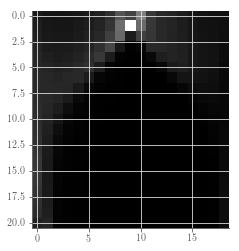

In [56]:
plt.imshow(scores)
plt.gray()
plt.show()

In [57]:
# get sorted indices
sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
print(sorted_indices)


[[19 13]
 [20 14]
 [20 13]
 [19 14]
 [18 14]
 [18 13]
 [17 14]
 [17 13]
 [20 12]
 [16 14]
 [20 15]
 [15 14]
 [19 15]
 [16 13]
 [19 12]
 [18 15]
 [14 14]
 [17 15]
 [15 13]
 [13 14]
 [18 12]
 [16 15]
 [20 11]
 [15 15]
 [12 14]
 [14 13]
 [14 15]
 [17 12]
 [20 16]
 [11 14]
 [19 16]
 [13 15]
 [19 11]
 [18 16]
 [17 16]
 [13 13]
 [12 15]
 [10 14]
 [16 16]
 [16 12]
 [15 16]
 [20 10]
 [18 11]
 [11 15]
 [14 16]
 [ 9 14]
 [12 13]
 [13 16]
 [15 12]
 [19 10]
 [17 11]
 [10 15]
 [12 16]
 [14 12]
 [11 13]
 [20  9]
 [16 11]
 [18 10]
 [13 12]
 [15 11]
 [17 10]
 [10 13]
 [12 12]
 [14 11]
 [16 10]
 [19  9]
 [ 9 13]
 [11 12]
 [18  9]
 [13 11]
 [15 10]
 [17  9]
 [10 12]
 [12 11]
 [14 10]
 [20  8]
 [ 8 13]
 [16  9]
 [19  8]
 [ 9 12]
 [11 11]
 [13 10]
 [15  9]
 [18  8]
 [ 8 12]
 [17  8]
 [10 11]
 [12 10]
 [14  9]
 [16  8]
 [20  7]
 [ 7 12]
 [11 10]
 [ 9 11]
 [13  9]
 [19  7]
 [15  8]
 [18  7]
 [12  9]
 [10 10]
 [ 8 11]
 [17  7]
 [14  8]
 [16  7]
 [11  9]
 [13  8]
 [ 9 10]
 [ 7 11]
 [20  6]
 [19  6]
 [15  7]
 

Pitches: 
[ 31.  34.  37.  40.  43.  46.  49.  52.  55.  58.  61.  64.  67.  70.  73.
  76.  79.  82.  85.  88.  91.]
Yaws: 
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.]
Score: 0.0294 -- Pitch: 37.0, Yaw: 70.0 (index 2, 7)


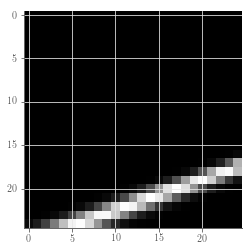

Score: 0.0295 -- Pitch: 37.0, Yaw: 100.0 (index 2, 10)


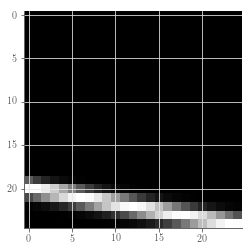

Score: 0.0306 -- Pitch: 31.0, Yaw: 90.0 (index 0, 9)


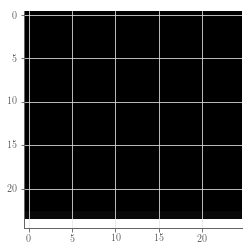

Score: 0.0327 -- Pitch: 40.0, Yaw: 70.0 (index 3, 7)


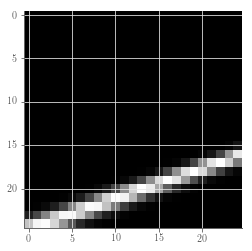

Score: 0.0385 -- Pitch: 31.0, Yaw: 80.0 (index 0, 8)


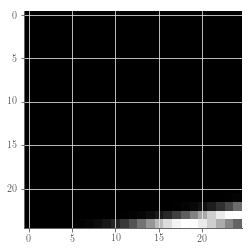

Score: 0.0480 -- Pitch: 37.0, Yaw: 80.0 (index 2, 8)


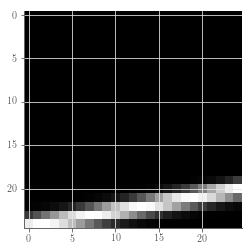

Score: 0.0486 -- Pitch: 34.0, Yaw: 100.0 (index 1, 10)


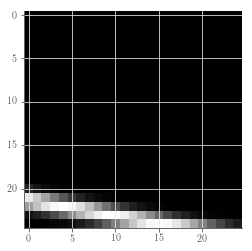

Score: 0.0498 -- Pitch: 34.0, Yaw: 80.0 (index 1, 8)


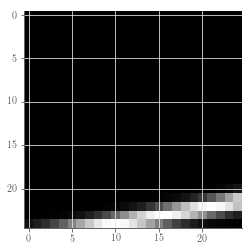

Score: 0.0577 -- Pitch: 31.0, Yaw: 100.0 (index 0, 10)


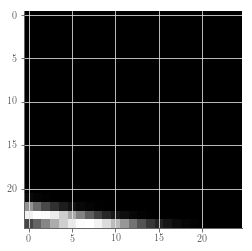

Score: 0.1168 -- Pitch: 34.0, Yaw: 90.0 (index 1, 9)


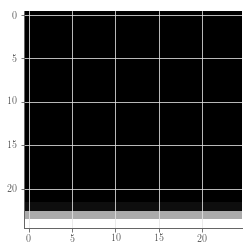

In [58]:
# look at the top 10 scores
print("Pitches: \n{0}".format(camera_pitches))
print("Yaws: \n{0}".format(camera_yaws))
for pitch_index, yaw_index in sorted_indices[-10:]:
    pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
    print("Score: {2:.4f} -- Pitch: {0}, Yaw: {1} (index {3}, {4})".format(pitch, yaw, scores[pitch_index, yaw_index], pitch_index, yaw_index))
    
    c = Camera(camera_position, pitch, yaw)
    c.set_resolution(25, 25)
    c.set_fov(*fov_deg)
    
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()

pitch, yaw: 52.0, 40.0, precomputed score: 0.700704650076
Sum pixel probabilities: 0.0343042458926
Ground distance: 3.14465064512, camera_z: 6.0, pixel_area0.34233494828
Z error: 0.0100750798934
orien error: 0.042893193268
pixel_error: 0.82744782105
2.70401089935
Ground distance: 19.7738144247, camera_z: 6.0, pixel_area18.1053000818
Z error: 0.063352907082
orien error: 0.405430679138
pixel_error: 6.01752442151
19.748203194
Ground distance: 2.56609276662, camera_z: 6.0, pixel_area0.684669896561
Z error: 0.00822145050599
orien error: 0.0397833689256
pixel_error: 1.17018793069
3.79714525581
Ground distance: 19.3324001368, camera_z: 6.0, pixel_area17.3040325201
Z error: 0.0619386691526
orien error: 0.388877765354
pixel_error: 5.88286197699
19.2987938757
Ground distance: 2.00376089812, camera_z: 6.0, pixel_area1.02700484484
Z error: 0.0064198072899
orien error: 0.0373630201502
pixel_error: 1.43318166667
4.63552334902
Ground distance: 18.9001024981, camera_z: 6.0, pixel_area16.5027649585
Z e

Z error: 19.0081558302
orien error: 5999993203.31
pixel_error: 187.756066258
5999993823.86
Ground distance: 16452.2086183, camera_z: 6.0, pixel_area818177.190137
Z error: 52.7108842786
orien error: 5999982683.96
pixel_error: 1279.20068022
5999986835.07
Ground distance: 40984.1925118, camera_z: 6.0, pixel_area2721597.7219
Z error: 131.30839019
orien error: 5999958151.97
pixel_error: 2333.06567499
5999965758.14
Ground distance: 93418.8311985, camera_z: 6.0, pixel_area13846191.138
Z error: 299.302623435
orien error: 5999905717.33
pixel_error: 5262.35520237
5999922876.58
Ground distance: 198335.38096, camera_z: 6.0, pixel_area49143427.6087
Z error: 635.442544929
orien error: 5999800800.78
pixel_error: 9913.97272628
5999833199.39
Ground distance: 396611.175957, camera_z: 6.0, pixel_area960771.539954
Z error: 1270.69418365
orien error: 5999602524.99
pixel_error: 1386.19734522
5999608236.89
Sum error bounds: 2.21998701947e+11
Score: 0.00125014063219


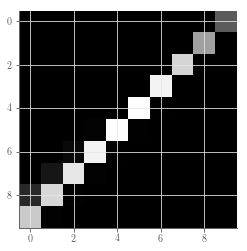

In [40]:
pitch_index, yaw_index= 7, 4
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(10, 10)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
error_bounds = error_radius_across_pixels(c)
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()

pitch, yaw: 52.0, 140.0, precomputed score: 1.02767848556
Sum pixel probabilities: 2.76201283519
Sum error bounds: -7.19978293655e+59
Score: 0.00315934354632


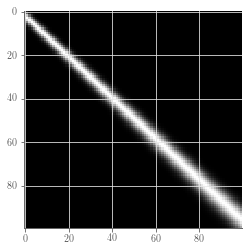

In [25]:
pitch_index, yaw_index= 7, 14
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(100, 100)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
print("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))
error_bounds = error_radius_across_pixels(c)
print("Sum error bounds: {0}".format(np.sum(error_bounds)))
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()

((399,), (399,), (399,))
(3.0, -10.0)


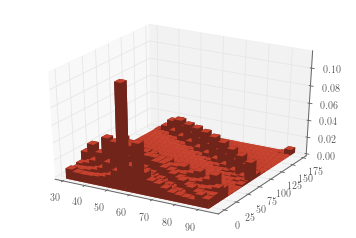

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scores_flat = scores.ravel()
ps, ys = np.meshgrid(camera_pitches, camera_yaws)
ps_, ys_ = ps.ravel(), ys.ravel()
bottom = np.zeros_like(ps_)
width = ps[0, 1] - ps[0,0]
depth = ys[0,0] - ys[1,0]
print(ps_.shape, ys_.shape, scores.ravel().shape)
print(width, depth)
ax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)
plt.show()

In [32]:
c2 = Camera(camera_position, 55, 25)
c2.set_resolution(200,200)

In [33]:
pixel_probabilities = c2.get_pixel_probabilities_for_road(road)

In [34]:
print(np.max(pixel_probabilities))

0.00398933856059


0.0


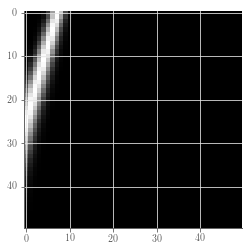

10.0


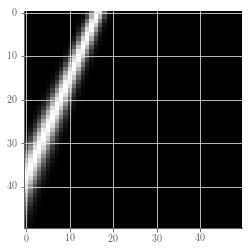

20.0


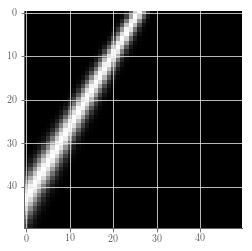

30.0


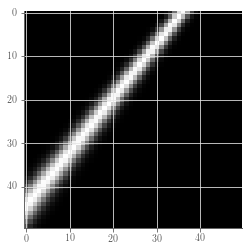

40.0


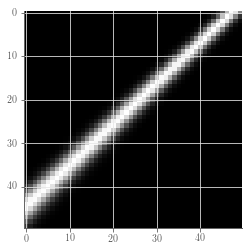

50.0


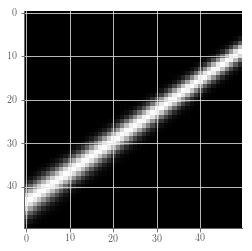

60.0


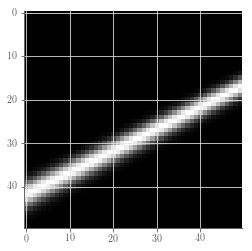

70.0


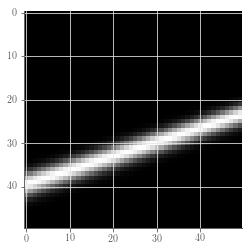

80.0


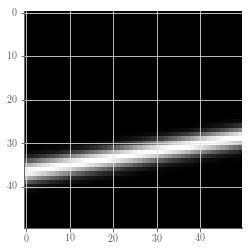

90.0


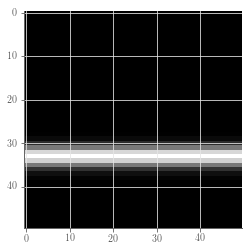

100.0


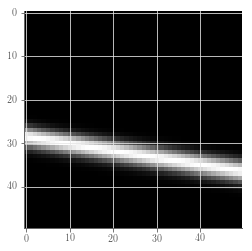

110.0


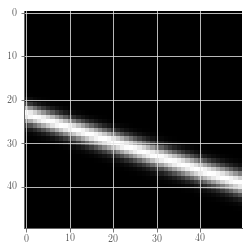

120.0


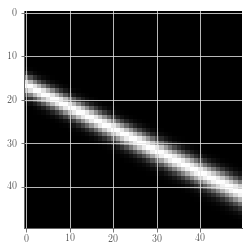

130.0


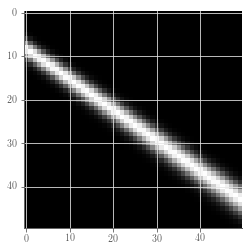

140.0


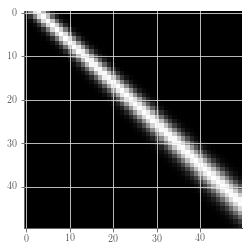

150.0


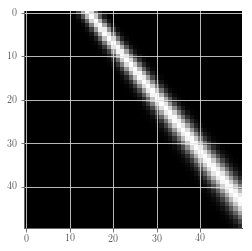

160.0


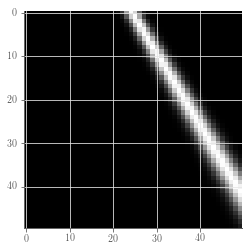

170.0


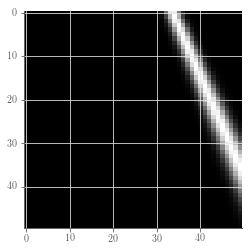

180.0


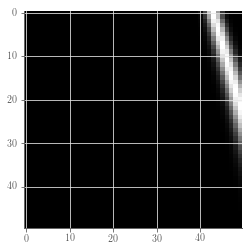

In [60]:
pitch = 55
for y in camera_yaws:
    print(y)
    c = Camera(camera_position, pitch, y)
    c.set_resolution(50, 50)
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    # flip the y axis for displaying as an image...
    
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()

In [39]:
camera_position

array([ 5., -3.,  6.])

In [59]:
pt = c.pixel_to_plane(85, 65)
road.get_perpendicular_distance_to_curve(pt)

0.28684051892920631

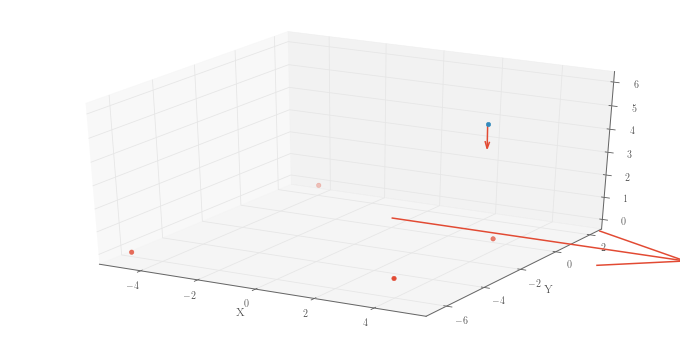

In [50]:
fig = plt.figure(figsize=(12,6))
ax= fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")

def plot_vector(axis, start, end):
    x,y,z = start
    u,v,w = end-start
    axis.quiver(x,y,z,u,v,w)

def plot_points(axis, pts):
    axis.scatter(pts[:, 0], pts[:, 1], pts[:, 2])
    

corners = np.array(c.get_corners())
corners[:, 2] = 0
plot_points(ax, corners)
plot_points(ax, np.array([camera_position]))
camera_principal = camera.orientation_vector
plot_vector(ax, camera_position, camera_principal+camera_position)
plot_vector(ax, road.path.get_point_at(0.0), road.path.get_point_at(10.0))
plt.show()


## Take into account Curvature
how to handle edge of roads? usually have an occlusion... ray trace, hit cylinder probably